In [1]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Nadam,Adamax,Adadelta
from keras import regularizers


Using TensorFlow backend.


In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
import numpy as np

In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [4]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 4s 0us/step


In [5]:
X_train.shape

(50000, 32, 32, 3)

In [6]:
X_test.shape

(10000, 32, 32, 3)

In [0]:
X_train_mean = np.mean(X_train, axis=(0,1,2))
X_train_std = np.std(X_train, axis=(0,1,2))
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1,horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(X_train, y_train, batch_size=64)


In [32]:
model.fit_generator(it_train, steps_per_epoch=steps, epochs=50, validation_data=(X_test, y_test),
                    callbacks=mycallbacks)

Epoch 1/50
10000/1250 [================================================================================================================================================================================================================================================] - 6s 599us/sample - loss: 1.2277 - acc: 0.6091

Epoch 00001: val_acc improved from -inf to 0.60910, saving model to best_model.h5
1250/1250 [==============================] - 206s 165ms/step - loss: 1.3758 - acc: 0.5115 - val_loss: 1.1671 - val_acc: 0.6091
Epoch 2/50
10000/1250 [================================================================================================================================================================================================================================================] - 4s 372us/sample - loss: 0.9240 - acc: 0.6867

Epoch 00002: val_acc improved from 0.60910 to 0.68670, saving model to best_model.h5
1250/1250 [==============================] - 118s 95ms/step - loss: 0.9228 - acc

In [0]:
steps = int(X_train.shape[0] / 40)


In [0]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        #if dropout_rate>0:
         #   Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2, k=2):
    global compression
    weight_decay = 1e-4
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same',kernel_regularizer=regularizers.l2(weight_decay))(relu)
    #if dropout_rate>0:
     #    Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.MaxPooling2D(pool_size=(k,k))(Conv2D_BottleNeck)
    #fractional=tf.nn.fractional_max_pool(Conv2D_BottleNeck,[1.5,1.42,1,1.5],pseudo_random=False,
    #overlapping=False)

    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.MaxPooling2D(pool_size=(2,2))(relu)
    temp = layers.Conv2D(num_classes, kernel_size = (2,2))(AvgPooling)
    flat = layers.Flatten()(temp)
    output=Activation('softmax')(flat)
    #output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [0]:
num_filter = 12
dropout_rate = 0.2
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, 32, dropout_rate,1)

My_First_Block = denseblock(First_Transition, num_filter, dropout_rate)
My_First_Transition = transition(My_First_Block, 32, dropout_rate,2)

Second_Block = denseblock(My_First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, 64, dropout_rate)

my_Second_Block = denseblock(My_First_Transition, num_filter, dropout_rate)
my_Second_Transition = transition(Second_Block, 64, dropout_rate,1)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, 128, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

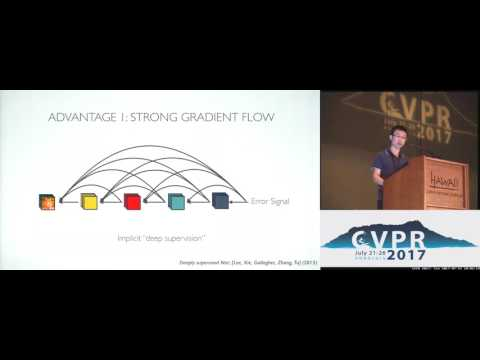

In [0]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [28]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_226 (Conv2D)             (None, 32, 32, 12)   324         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_221 (BatchN (None, 32, 32, 12)   48          conv2d_226[0][0]                 
__________________________________________________________________________________________________
activation_224 (Activation)     (None, 32, 32, 12)   0           batch_normalization_221[0][0]    
____________________________________________________________________________________________

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

filepath="epochs:{epoch:03d}-val_acc:{val_acc:.3f}.h5"
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
mycallbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule),mc]

In [0]:
# determine Loss function and Optimizer
sgd = SGD(lr=0.0008, nesterov=True, decay=0.0005)

opt_rms = RMSprop(lr=0.001,decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt_rms,
              metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1, 
                    validation_data=(X_test, y_test),callbacks=mycallbacks)

In [0]:
def lr_schedule(epoch):
    lrate = 0.00015
    return lrate

filepath="epochs:{epoch:03d}-val_acc:{val_acc:.3f}.h5"
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
mycallbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule),mc]

In [0]:
from keras.models import load_model
saved_model = load_model('best_model.h5')

In [0]:
# Test the model
score = saved_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 6s 558us/sample - loss: 0.3678 - acc: 0.8920
Test loss: 0.36782966589927674
Test accuracy: 0.892


In [0]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lrate = 0.0005
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

filepath="epochs:{epoch:03d}-val_acc:{val_acc:.3f}.h5"
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
mycallbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule),mc]

In [34]:
model.fit_generator(it_train, steps_per_epoch=steps, epochs=50, validation_data=(X_test, y_test),
                    callbacks=mycallbacks)

Epoch 1/50
10000/1250 [================================================================================================================================================================================================================================================] - 4s 351us/sample - loss: 0.5466 - acc: 0.8804

Epoch 00001: val_acc improved from -inf to 0.88040, saving model to best_model.h5
1250/1250 [==============================] - 114s 91ms/step - loss: 0.1880 - acc: 0.9424 - val_loss: 0.4468 - val_acc: 0.8804
Epoch 2/50
10000/1250 [================================================================================================================================================================================================================================================] - 4s 354us/sample - loss: 0.5378 - acc: 0.8878

Epoch 00002: val_acc improved from 0.88040 to 0.88780, saving model to best_model.h5
1250/1250 [==============================] - 112s 90ms/step - loss: 0.1827 - acc:

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lrate = 0.0003
    return lrate

filepath="epochs:{epoch:03d}-val_acc:{val_acc:.3f}.h5"
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
mycallbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule),mc]

In [36]:
model.fit_generator(it_train, steps_per_epoch=steps, epochs=30, validation_data=(X_test, y_test),
                    callbacks=mycallbacks)

Epoch 1/30
10000/1250 [================================================================================================================================================================================================================================================] - 4s 358us/sample - loss: 0.4696 - acc: 0.8939

Epoch 00001: val_acc improved from -inf to 0.89390, saving model to best_model.h5
1250/1250 [==============================] - 113s 91ms/step - loss: 0.1109 - acc: 0.9674 - val_loss: 0.4763 - val_acc: 0.8939
Epoch 2/30
10000/1250 [================================================================================================================================================================================================================================================] - 4s 358us/sample - loss: 0.5577 - acc: 0.8909

Epoch 00002: val_acc did not improve from 0.89390
1250/1250 [==============================] - 113s 90ms/step - loss: 0.1075 - acc: 0.9683 - val_loss: 0.4962 - val_ac

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lrate = 0.00015
    return lrate

filepath="epochs:{epoch:03d}-val_acc:{val_acc:.3f}.h5"
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
mycallbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule),mc]

In [0]:
steps = int(X_train.shape[0] / 64)

In [39]:
model.fit_generator(it_train, steps_per_epoch=steps, epochs=20, validation_data=(X_test, y_test),
                    callbacks=mycallbacks)

Epoch 1/20
10000/781 [================================================================================================================================================================================================================================================================================================================================================================================================] - 4s 354us/sample - loss: 0.5559 - acc: 0.8933

Epoch 00001: val_acc improved from -inf to 0.89330, saving model to best_model.h5
781/781 [==============================] - 73s 93ms/step - loss: 0.0861 - acc: 0.9759 - val_loss: 0.5486 - val_acc: 0.8933
Epoch 2/20
10000/781 [=============================================================================================================================================================================================================================================================================================================================

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lrate = 0.0001
    return lrate

filepath="epochs:{epoch:03d}-val_acc:{val_acc:.3f}.h5"
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
mycallbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule),mc]

In [42]:
model.fit_generator(it_train, steps_per_epoch=steps, epochs=20, validation_data=(X_test, y_test),
                    callbacks=mycallbacks)

Epoch 1/20
10000/781 [================================================================================================================================================================================================================================================================================================================================================================================================] - 4s 352us/sample - loss: 0.4523 - acc: 0.8979

Epoch 00001: val_acc improved from -inf to 0.89790, saving model to best_model.h5
781/781 [==============================] - 72s 92ms/step - loss: 0.0717 - acc: 0.9802 - val_loss: 0.5275 - val_acc: 0.8979
Epoch 2/20
10000/781 [=============================================================================================================================================================================================================================================================================================================================

In [45]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 5s 460us/sample - loss: 0.5443 - acc: 0.9001
Test loss: 0.5443131398320198
Test accuracy: 0.9001


In [0]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lrate = 0.00005
    return lrate

filepath="epochs:{epoch:03d}-val_acc:{val_acc:.3f}.h5"
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
mycallbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule),mc]

In [47]:
model.fit_generator(it_train, steps_per_epoch=1.2*steps, epochs=10, validation_data=(X_test, y_test),
                    callbacks=mycallbacks)

Epoch 1/10
10000/937 [================================================================================================================================================================================================================================================================================================================================] - 4s 374us/sample - loss: 0.5182 - acc: 0.8993

Epoch 00001: val_acc improved from -inf to 0.89930, saving model to best_model.h5
938/937 [==============================] - 88s 93ms/step - loss: 0.0659 - acc: 0.9821 - val_loss: 0.5511 - val_acc: 0.8993
Epoch 2/10
10000/937 [================================================================================================================================================================================================================================================================================================================================] - 4s 390us/sample - loss: 0.5119 - acc: 0.9004

Epoch 00002

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

# create data generator
datagen = ImageDataGenerator(width_shift_range=0.01, height_shift_range=0.01,horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(X_train, y_train, batch_size=64)

In [49]:
model.fit_generator(it_train, steps_per_epoch=1.2*steps, epochs=10, validation_data=(X_test, y_test),
                    callbacks=mycallbacks)

Epoch 1/10
10000/937 [================================================================================================================================================================================================================================================================================================================================] - 4s 353us/sample - loss: 0.4619 - acc: 0.9029

Epoch 00001: val_acc improved from 0.90040 to 0.90290, saving model to best_model.h5
938/937 [==============================] - 85s 91ms/step - loss: 0.0428 - acc: 0.9905 - val_loss: 0.5019 - val_acc: 0.9029
Epoch 2/10
10000/937 [================================================================================================================================================================================================================================================================================================================================] - 3s 349us/sample - loss: 0.4620 - acc: 0.9035

Epoch 00

In [50]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 4s 426us/sample - loss: 0.5175 - acc: 0.9035
Test loss: 0.5175371741235256
Test accuracy: 0.9035
